# Importing Packages

In [1]:
import pyift.pyift as ift
import matplotlib.pyplot as plt
import numpy as np

import os
from PIL import Image
import numpy as np
from tqdm import tqdm
import shutil

from sklearn.model_selection import train_test_split, KFold

import cv2

In [2]:
import sys
sys.path.append('../')
sys.path.append('../utilities')
from utilities.utils import * 

In [3]:
# Setting random seed for reproducibility
seed_num = 420
np.random.seed(seed_num)

# 1.0 Visualizing the Dataset and Ground Truth

In [4]:
folder_path = 'datasets/iris'
ground_truth_path = 'datasets/ground_truth'


image_paths, ground_truth_paths,  image_files, ground_truth_files = setup_image_paths(folder_path, 
                                                                                      ground_truth_path)

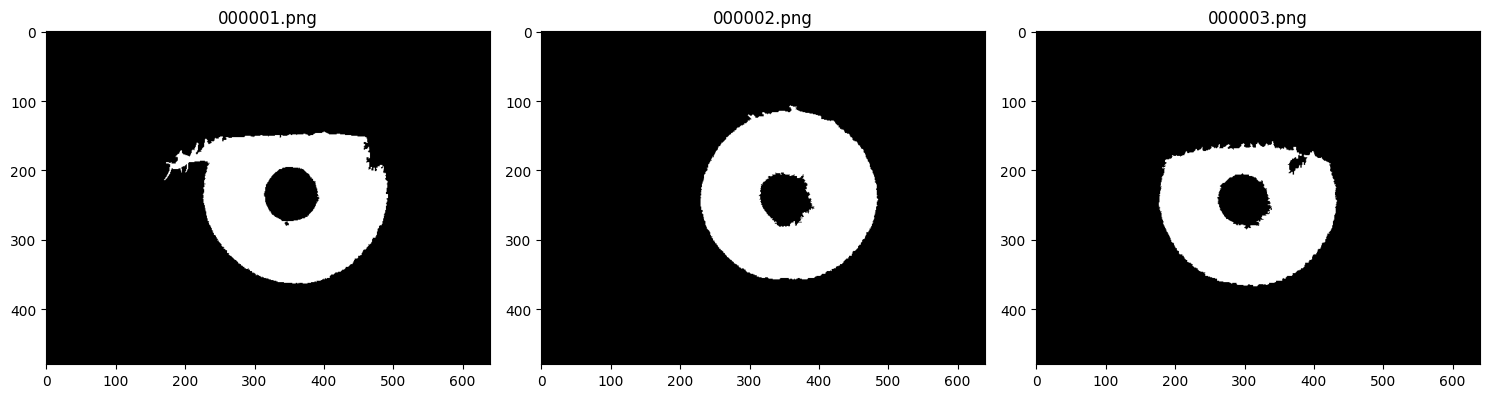

In [5]:
plot_images_in_grid(image_paths=ground_truth_paths[0:3],
                    image_titles=ground_truth_files[0:3],
                    rows=1, cols=3, figsize=(15, 6))

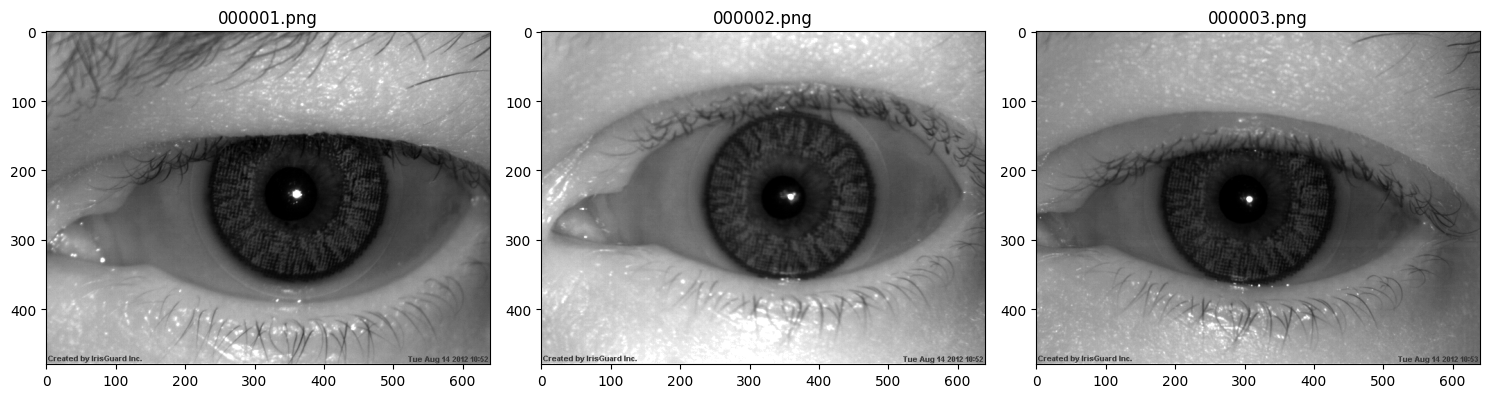

In [6]:
plot_images_in_grid(image_paths=image_paths[0:3],
                    image_titles=image_files[0:3],
                    rows=1, cols=3, figsize=(15, 6))

# 2.0 Creating the Experiment Datasets

Here we have to create 4 different experiments with training, validation and test sets. 

In [7]:
numbers = list(range(1, 101))
train, test = train_test_split(numbers, test_size=20, random_state=seed_num)

K fold for generating the 4 experiments based on the training set

In [8]:
kf = KFold(n_splits=4, shuffle=True, random_state=seed_num)
folds = list(kf.split(train))

In [9]:
training_validation_sets = []
for i, (train_index, val_index) in enumerate(folds):
    train_set = [train[i] for i in train_index]
    val_set = [train[i] for i in val_index]
    training_validation_sets.append((train_set, val_set))

# Ground truth and training/validation images share the same name
ground_truth_training_validation_sets = training_validation_sets

In [10]:
for i, (train_set, val_set) in enumerate(training_validation_sets):
    print(f"Fold {i+1}:")
    print("Training set:", train_set)
    print("Validation set:", val_set)
    print("--------------")
    
print("Test set:", test)
print("--------------")

Fold 1:
Training set: [31, 98, 21, 59, 39, 80, 57, 28, 84, 92, 81, 63, 95, 4, 62, 30, 54, 87, 69, 23, 35, 51, 67, 100, 88, 33, 71, 40, 82, 83, 12, 74, 76, 79, 90, 29, 94, 97, 53, 6, 60, 3, 96, 77, 48, 38, 78, 65, 55, 5, 25, 36, 85, 24, 99, 27, 58, 32, 64, 50]
Validation set: [66, 56, 16, 17, 93, 2, 44, 37, 91, 89, 86, 72, 10, 9, 70, 15, 11, 47, 7, 73]
--------------
Fold 2:
Training set: [66, 98, 59, 39, 80, 56, 57, 28, 84, 92, 81, 63, 95, 16, 17, 93, 2, 44, 54, 87, 37, 69, 91, 23, 35, 67, 89, 33, 40, 83, 86, 72, 74, 10, 76, 79, 90, 94, 60, 3, 9, 96, 77, 70, 38, 78, 55, 5, 25, 85, 15, 99, 11, 27, 58, 47, 32, 64, 7, 73]
Validation set: [31, 21, 4, 62, 30, 51, 100, 88, 71, 82, 12, 29, 97, 53, 6, 48, 65, 36, 24, 50]
--------------
Fold 3:
Training set: [66, 31, 21, 59, 39, 80, 56, 84, 63, 95, 4, 62, 16, 17, 93, 2, 44, 30, 54, 87, 37, 69, 91, 35, 51, 67, 100, 89, 88, 33, 71, 40, 82, 86, 72, 12, 10, 79, 29, 94, 97, 53, 6, 3, 9, 77, 48, 70, 65, 55, 5, 36, 15, 24, 11, 27, 47, 7, 73, 50]
Valid

# 3.0 Saving the Data into Different Experiment Folders

Creating the folders

In [11]:
base_dir = 'Experiments'
if not os.path.exists(base_dir):
    os.makedirs(base_dir)

Create folders for each fold - training and validation set

In [12]:
for i in range(1, 5):
    
    # Inside the Experiment folder, create the experiment number folder
    exp_dir = os.path.join(base_dir, f'Experiment_{i}') 
    
    # For each experiment number folder, create the training, validation and ground truth folder that will contain the images
    train_dir = os.path.join(exp_dir, 'train') 
    val_dir = os.path.join(exp_dir, 'val')
    train_ground_truth_dir = os.path.join(exp_dir, 'train_ground_truth')
    val_ground_truth_dir = os.path.join(exp_dir, 'val_ground_truth')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(train_ground_truth_dir, exist_ok=True)
    os.makedirs(val_ground_truth_dir, exist_ok=True)
    
    # For each experiment number folder, create the training and validation folder that will contain the activation maps of the images
    train_dir_activ_maps = os.path.join(exp_dir, 'train_activ_maps')
    val_dir_activ_maps = os.path.join(exp_dir, 'val_activ_maps')
    os.makedirs(train_dir_activ_maps, exist_ok=True)
    os.makedirs(val_dir_activ_maps, exist_ok=True)
    
    # Directory for saving the FLIM Model
    train_flim_model_sir = os.path.join(exp_dir, 'train_flim_model')
    val_flim_model_sir = os.path.join(exp_dir, 'val_flim_model')
    os.makedirs(train_flim_model_sir, exist_ok=True)
    os.makedirs(val_flim_model_sir, exist_ok=True)
    
    # For each experiment number folder, create the folders to save the activation maps and markers
    marker_dir = os.path.join(exp_dir, 'markers')
    os.makedirs(marker_dir, exist_ok=True)

Creating folders for the test set

In [13]:
# Since we NEVER touch the test set, it will be separated from the experiment number folders
test_dir = os.path.join(base_dir, 'test')
test_ground_truth_dir = os.path.join(base_dir, 'test_ground_truth')

# After the FLIM encoder and Image processing pipeline, we will have to pass the test data through the
# best experiment pipeline and save the test activation maps there
test_dir_activ_maps = os.path.join(base_dir, 'test_activ_maps')

os.makedirs(test_dir, exist_ok=True)
os.makedirs(test_dir_activ_maps, exist_ok=True)
os.makedirs(test_ground_truth_dir, exist_ok=True)

Saving the data to the corresponding folders - training and validation set

In [14]:
# Copy the training and validation images for each fold
for i, (train_index, val_index) in enumerate(folds):
    train_set = [train[i] for i in train_index]
    val_set = [train[i] for i in val_index]
    
    exp_dir = os.path.join(base_dir, f'Experiment_{i+1}')
    train_dir = os.path.join(exp_dir, 'train')
    val_dir = os.path.join(exp_dir, 'val')
    train_ground_truth_dir = os.path.join(exp_dir, 'train_ground_truth')
    val_ground_truth_dir = os.path.join(exp_dir, 'val_ground_truth')
    
    for num in train_set:
        img_file = f'{num:06}.png'
        shutil.copy(os.path.join(folder_path, img_file), train_dir)
        shutil.copy(os.path.join(ground_truth_path, img_file), train_ground_truth_dir)
    
    for num in val_set:
        img_file = f'{num:06}.png'
        shutil.copy(os.path.join(folder_path, img_file), val_dir)
        shutil.copy(os.path.join(ground_truth_path, img_file), val_ground_truth_dir)

Saving the ground truth to the test folder

In [15]:
for num in test:
    img_file = f'{num:06}.png'
    shutil.copy(os.path.join(folder_path, img_file), test_dir) # Copy the test images
    shutil.copy(os.path.join(ground_truth_path, img_file), test_ground_truth_dir) # Copy the test ground truth images

In [16]:
print("Folders and files have been organized successfully.")

Folders and files have been organized successfully.


# 4.0 Running FLIMBuilder

After we run the FLIMBuilder app, we want to copy all files from there to the corresponding experiment

We want to copy the training dataset activation maps from the 'FLIM_Model' file to the file 'train_activ_maps' since we are doing the visual analysis `ONLY` on training set. With the model defined, we use the same architecture and markers for the validation data.

`Note that the function above must be run two times per experiment`:

1) The first to define the architecture and marker files. Then we obtain the mean, std, bias, and activation map files
2) The second to obtain the validation mean, std, bias and activation map files. WE DO NOT USE THIS INFORMATION TO DEFINE ANYTHING

## 4.1 Running for the First Time 

We import the training data, select a random image from this data to train the model, define the markers and run the train and extract feature option.

After training, we copy the model to the folder `train_flim_model`

In [17]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [24]:
src_dir = '/home/arthur/Documents/MO445A/ift/ift/bin/model'
#dest_train_exp_dir1 = '/home/arthur/Downloads/Trabalho_2/Experiments/Experiment_1/train_flim_model'
#dest_train_exp_dir2 = '/home/arthur/Downloads/Trabalho_2/Experiments/Experiment_2/train_flim_model'
#dest_train_exp_dir3 = '/home/arthur/Downloads/Trabalho_2/Experiments/Experiment_3/train_flim_model'
dest_train_exp_dir4 = '/home/arthur/Downloads/Trabalho_2/Experiments/Experiment_4/train_flim_model'

#copy_model_files(src_dir, dest_train_exp_dir1,delete_existing=True)
#copy_model_files(src_dir, dest_train_exp_dir2,delete_existing=True)
#copy_model_files(src_dir, dest_train_exp_dir3,delete_existing=True)
copy_model_files(src_dir, dest_train_exp_dir4,delete_existing=True)

All files from /home/arthur/Documents/MO445A/ift/ift/bin/model have been copied to /home/arthur/Downloads/Trabalho_2/Experiments/Experiment_4/train_flim_model


The bias files will be created with the terminal using the file `iftFLIM-ConvertModel2Bias.c`, while the FLIM decoder will be run with the function `iftSalienceMaps.c`

Inside this function, we can save the files in the folder `train_activ_maps`

In [ ]:
break

## 4.2 Running for the Second Time 

We do not need to train the model anymore, since we will use the model of Section 4.1. We only need to pass the validation dataset to the trained model and use the option `Extract Features`. Then we save the model to the folder `val_flim_model`

In [25]:
# dest_val_exp_dir1 = '/home/arthur/Downloads/Trabalho_2/Experiments/Experiment_1/val_flim_model'
#dest_val_exp_dir2 = '/home/arthur/Downloads/Trabalho_2/Experiments/Experiment_2/val_flim_model'
#dest_val_exp_dir3 = '/home/arthur/Downloads/Trabalho_2/Experiments/Experiment_3/val_flim_model'
dest_val_exp_dir4 = '/home/arthur/Downloads/Trabalho_2/Experiments/Experiment_4/val_flim_model'


#copy_model_files(src_dir, dest_val_exp_dir1,delete_existing=True)
#copy_model_files(src_dir, dest_val_exp_dir2,delete_existing=True)
#copy_model_files(src_dir, dest_val_exp_dir3,delete_existing=True)
copy_model_files(src_dir, dest_val_exp_dir4,delete_existing=True)

All files from /home/arthur/Documents/MO445A/ift/ift/bin/model have been copied to /home/arthur/Downloads/Trabalho_2/Experiments/Experiment_4/val_flim_model


The bias files will be created with the terminal using the file `iftFLIM-ConvertModel2Bias.c`, while the FLIM decoder will be run with the function `iftSalienceMaps.c`. The commands used are in `terminal_cmds.txt`

Inside this function, we can save the files in the folder `val_activ_maps`

# 5.0 FLIM decoder Results

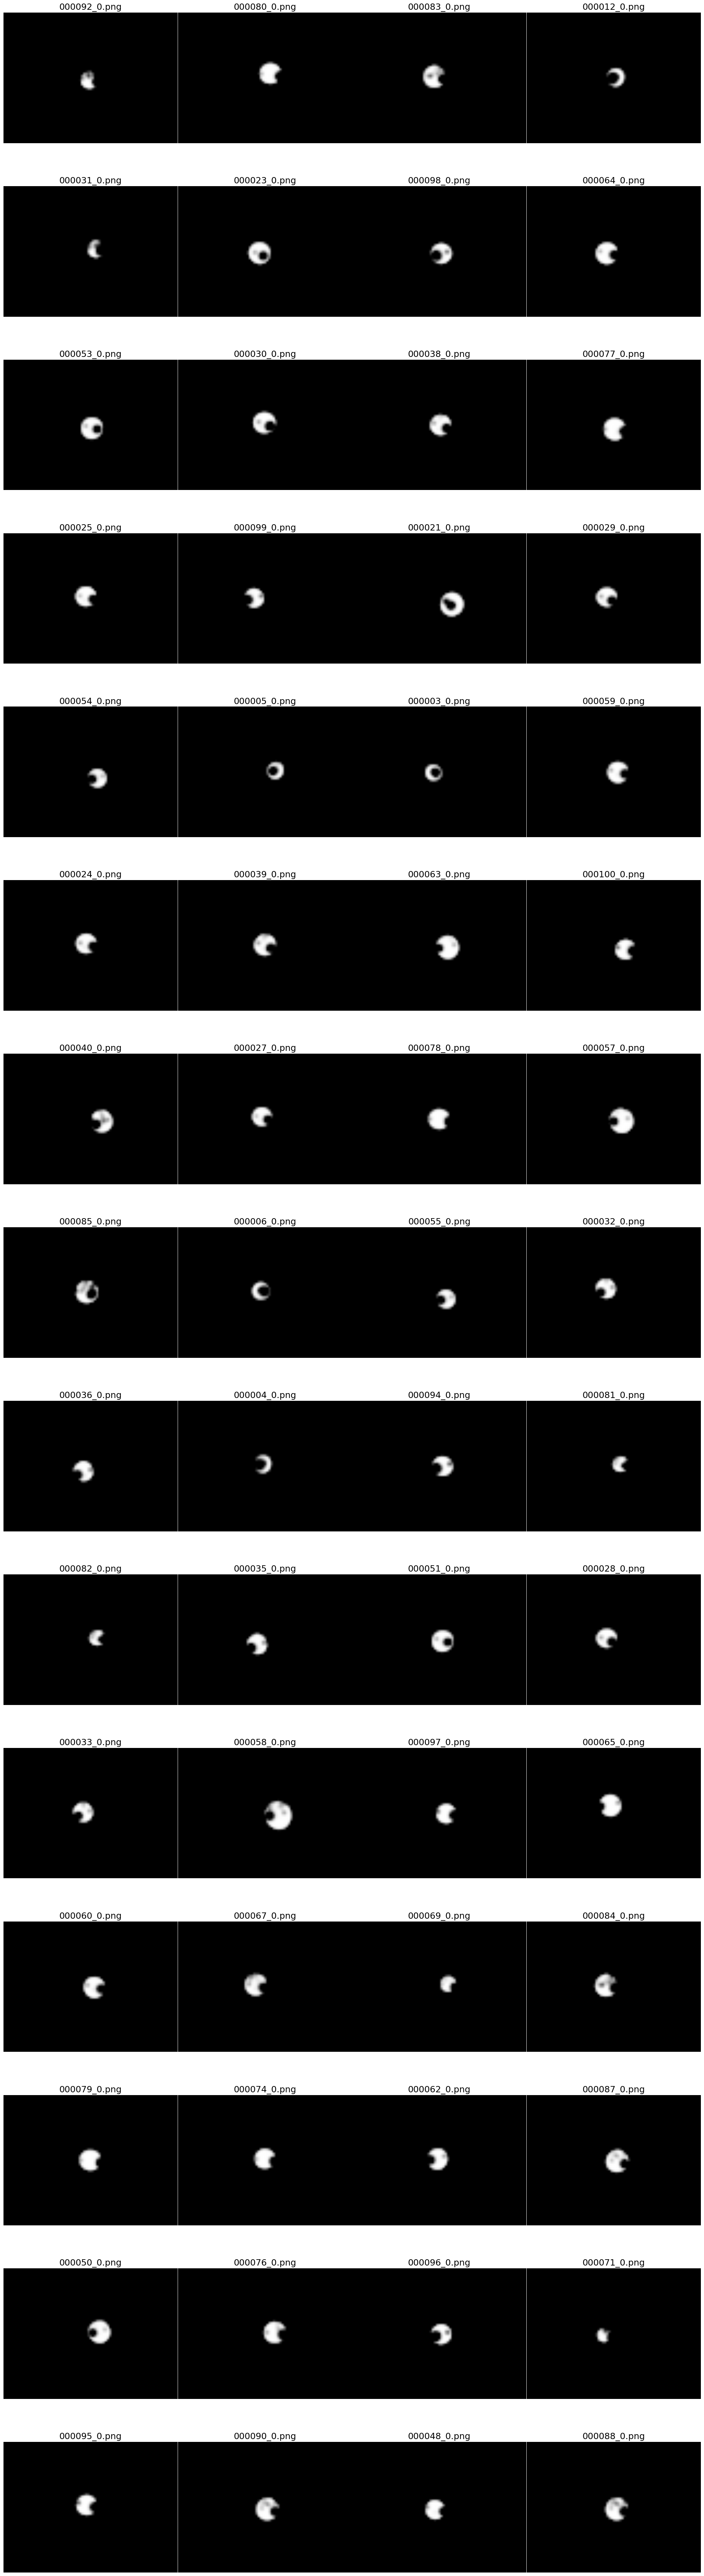

In [ ]:
image_folder = 'Experiments/Experiment_1/train_activ_maps'
save_folder = 'Figures'
load_and_plot_images(image_folder = image_folder,
                     save_folder = save_folder)